In [1]:
library(stringr)
library(RColorBrewer)

In [2]:
set.seed(10)

In [3]:
cibers = list.files(path = "../tables/Cibersort_out", pattern = "mouse", full.names = T)
cibers = cibers[! cibers %in% cibers[10]]
cibers = cibers[! cibers %in% cibers[13]]

In [4]:
cibers = cibers[c(8, 3, 4, 7, 10,
                5, 1, 13, 9, 2,
                11, 12, 14, 6)]

# Process GTEx sample ids

In [5]:
gtex_samples   = read.table("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", header = TRUE, sep = "\t")

In [6]:
tissue2tissue = data.frame( tissue_name = c("atrium", "liver", "aorta", "bladder", "colon", 
                            "spleen", "brain.nonmicroglia", "fat", "kidney", "mammary", 
                            "muscle", "pancreas", "skin", "ventricle"),
          
            gtex_SMTS   = c("Heart", "Liver", "Blood Vessel", "Bladder", "Colon",
                            "Spleen", "Brain", "Adipose Tissue", "Kidney", "Breast",
                            "Muscle", "Pancreas", "Skin", "Heart"))

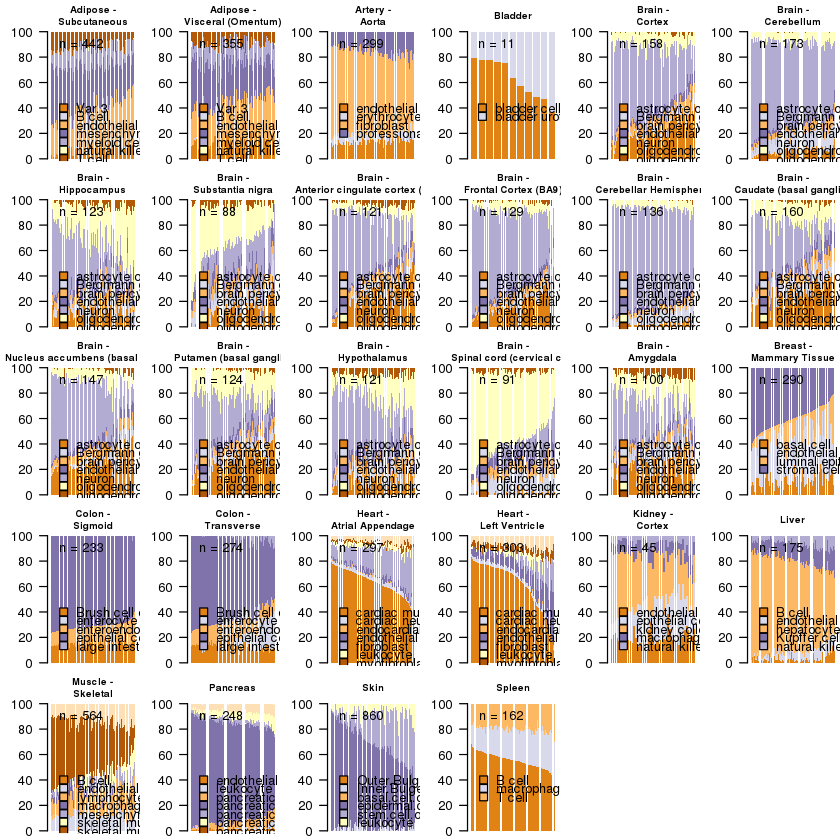

In [9]:

par(mfrow = c(5, 6), mar = c(0.5, 3, 2, .1))
for( tissue in cibers){
    
    tissue_name = str_split_fixed(basename(tissue), "_", 5)[,3]
    estimates = read.csv(tissue)
    gtextiss = tissue2tissue[tissue2tissue$tissue_name == tissue_name, "gtex_SMTS"]
    subtissues = unique(gtex_samples[gtex_samples$SMTS == gtextiss, "SMTSD"])
    
    if( tissue_name == "atrium"){ subtissues = subtissues[! subtissues %in% "Heart - Left Ventricle"]}
    if( tissue_name == "ventricle"){ subtissues = subtissues[! subtissues %in% "Heart - Atrial Appendage"]}
    if( tissue_name == "aorta"){ subtissues = subtissues[ subtissues %in% 'Artery - Aorta']}
    
    if( tissue_name == "skin"){ 
        subtissues = subtissues[! subtissues %in% "Cells - Transformed fibroblasts"]
        ciber = estimates
        CiberBarFrazer(ciber, "Skin", 50)
        
    } 
    
    if(! tissue_name == "skin"){ 
        for(subtissue in subtissues){

            sampleids = gtex_samples[gtex_samples$SMTSD == subtissue, "SAMPID"]
            ciber = estimates[estimates$Input.Sample %in% sampleids, ]

            CiberBarFrazer(ciber, subtissue, 50)
        }
    }
    
}

# Plot Function

In [8]:
set.seed(3)
colorblindfriendlypal = sample(c("#b35806",
                                 "#e08214",
                                 "#fdb863",
                                 "#fee0b6",
                                 "#ffffbf",
                                 "#d8daeb",
                                 "#b2abd2",
                                 "#8073ac"
                                 ), 8)

CiberBarFrazer <- function(ciber, main0, legy){
    
    rownames(ciber) <- ciber$Input.Sample
    ciber$Input.Sample <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    
    ciber = ciber[order(-ciber[, rev(order(colMeans(ciber)))[1]], -ciber[, rev(order(colMeans(ciber)))[2]]), ]
    
    nsamples = nrow(ciber)
    ciber = as.data.frame(t(ciber) * 100)
    
    ciber$color = colorblindfriendlypal[1:nrow(ciber)]
    
    main0 = gsub(" - ", " -\n", main0)
    
    barplot(as.matrix(ciber[, seq(1, (ncol(ciber) - 1))]), las = 2, col = ciber$color, border=NA, names.arg = rep("", ncol(ciber) - 1), 
           ylab = "Fraction clusters", main = main0, cex.main = .75)

    text(nsamples * .005, 90, paste("n = ", nsamples, sep = ""), pos = 4)

    legend(0, legy,
           gsub("_", " ", rownames(ciber)),
           
           bty = "n",
           pch = rep(22, nrow(ciber)),
           pt.cex = rep(1.5, nrow(ciber)),
           pt.bg = colorblindfriendlypal[1:nrow(ciber)],
           y.intersp = 0.5
           )
        
}

# 

In [289]:
fs = list.files(path = "../tables/Cibersort_out/", pattern = "mouse.csv", all.files = FALSE, full.names = TRUE)
fs = fs[! fs %in% '../tables/Cibersort_out//CIBERSORT.Output_Job93_lung_mouse.csv']

In [290]:
CalculateAverageDFromtheMean <- function(f){
    
    df = read.csv(f)
    rownames(df) = df[,1]
    df[,1] <- NULL
    df = df[, seq(1, (ncol(df) - 3))]
    L = ncol(df)
    N = nrow(df)
    mean = 1.0 / L


    for(subject in seq(1, N)){
        for(ct in seq(1, L)){
            ct_mean = mean(df[, ct])
            df[subject, paste("SDM", ct, sep = "_")] = (((df[subject, ct] - ct_mean)^2) / (ct_mean^2)) #* (N * (L*(N - 1))) #average distance from the mean
        }    
    }
    df.sdm = df[, grep("SDM", colnames(df))]
    
    return(df.sdm)
    
    
}

In [291]:
df.sdm = CalculateAverageDFromtheMean(fs[1])

var = list()
for(f in fs[1:length(fs)]){
    
    tiss = str_split_fixed(f, "_", 5)[, 4]
    df.sdm = CalculateAverageDFromtheMean(f)
    var[[tiss]] <- log(rowMeans(df.sdm) , 2)
    
}



In [292]:
gtex.meta = read.csv("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", sep = "\t")

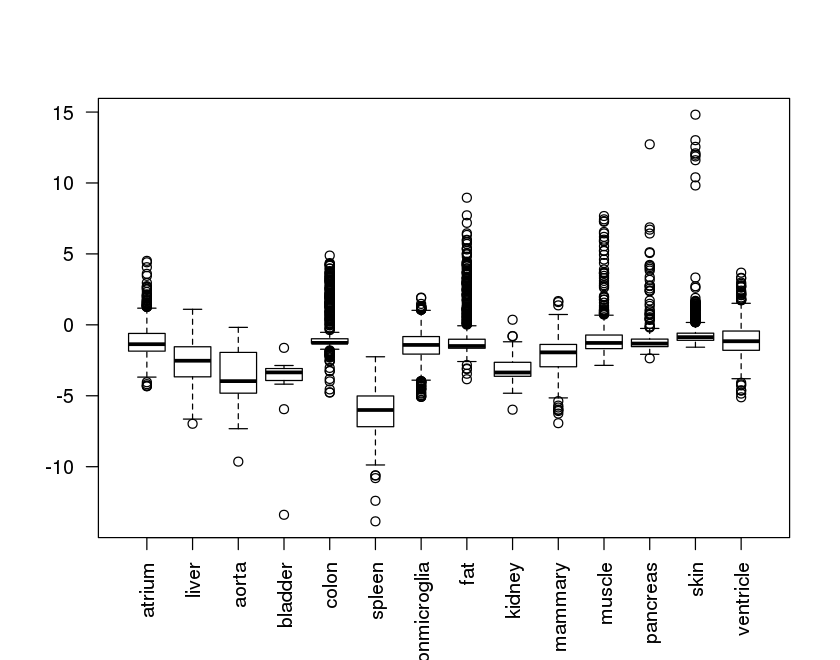

In [295]:
boxplot(var, las = 2)

In [297]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS: /frazer01/home/matteo/software/R-3.5.1/lib/libRblas.so
LAPACK: /frazer01/home/matteo/software/R-3.5.1/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-2 stringr_1.4.0     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1      zeallot_0.1.0   digest_0.6.19   crayon_1.3.4   
 [5] IRdisplay_0.7.0 repr_1.0.1      backports_1.1.4 jsonlite_1.6   
 [9] magrittr_1.5    evaluate_0